In [1]:
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pandas as pd
from numpy import quantile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data

In [2]:
""" SPX ticker symbol is ^GSPC on Yahoo Finance """
from_date = datetime.datetime(1960, 1, 1) 
to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=' + from_date.strftime('%s') + '&period2=' + to_date.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/spx_HistoricalData.csv'
max_age_days = 7

df = load_data(csv_url, local_file, max_age_days)

In [3]:
""" Data Transformation """
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1960-01-04,59.910000,59.910000,59.910000,59.910000,59.910000,3990000
1960-01-05,60.389999,60.389999,60.389999,60.389999,60.389999,3710000
1960-01-06,60.130001,60.130001,60.130001,60.130001,60.130001,3730000
1960-01-07,59.689999,59.689999,59.689999,59.689999,59.689999,3310000
1960-01-08,59.500000,59.500000,59.500000,59.500000,59.500000,3290000


In [4]:
""" Chart Variables"""
start_year = 1960

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df['Adj Close'].last_valid_index()

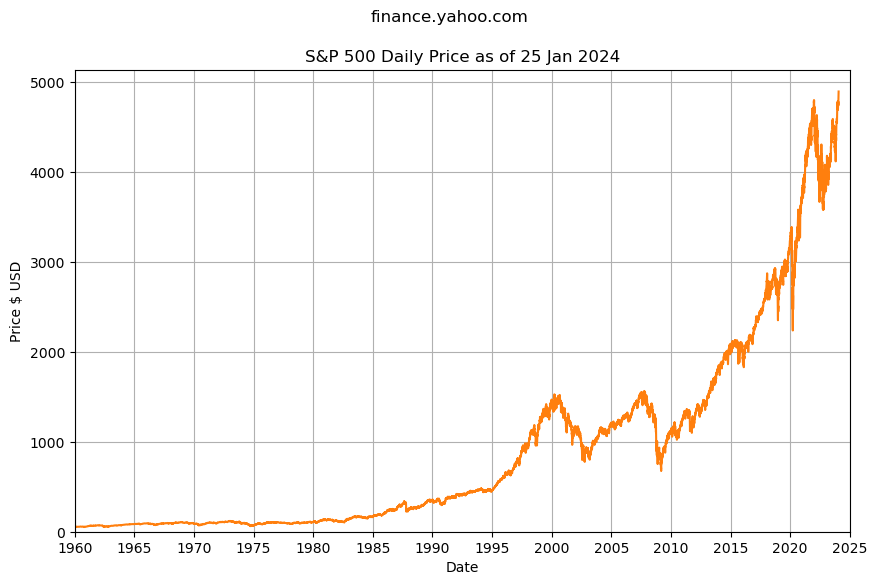

In [5]:
plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Adj Close'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Price $ USD')
plt.suptitle('finance.yahoo.com')
plt.title('S&P 500 Daily Price as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
plt.ylim(bottom=0) #, top=top_limit)     
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.grid(True)

plt.savefig(os.path.join('..', 'pages', 'images', 'spx-history.png'), bbox_inches='tight')
plt.show()



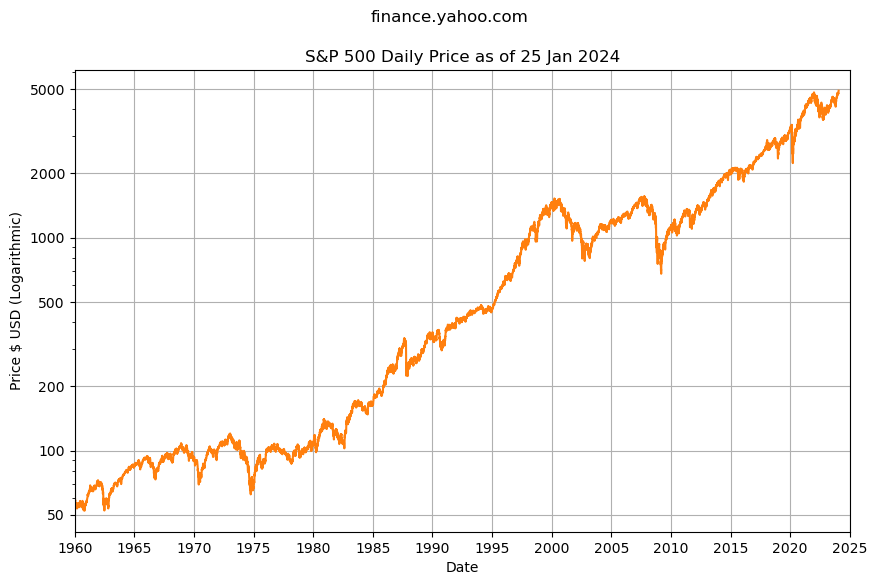

In [6]:
# Define the y-tick values and labels
yticks = [50, 100, 200, 500, 1000, 2000, 5000]
yticksformatted = [f'{ytick:.0f}' for ytick in yticks]
yticklabels = [str(ytick) for ytick in yticks]

plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Adj Close'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Price $ USD (Logarithmic)')
plt.suptitle('finance.yahoo.com')
plt.title('S&P 500 Daily Price as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
plt.yscale('log')
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
plt.yticks(yticks, yticklabels)
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.grid(True)

plt.savefig(os.path.join('..', 'pages', 'images', 'spx-history-log.png'), bbox_inches='tight')
plt.show()



In [7]:
""" Year over Year (YoY) change based on 252 trading days per year """
annual_trading_days = 252
df['YoY'] = df['Adj Close'].pct_change(periods=annual_trading_days)*100

quantile_lower = 0.25
quantile_median = 0.5
quantile_upper = 0.75
multi_year = 10

# Calculate the lower and upper percentile over the previous 1 year
df['YoY_lower'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_lower)
df['YoY_median'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_median)
df['YoY_upper'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_upper)

# Add multi-year 
df['MY_lower'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_lower)
df['MY_median'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_median)
df['MY_upper'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_upper)

# Add multi-year 
df['MY3_lower'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*3)).quantile(quantile_lower)
df['MY3_median'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*3)).quantile(quantile_median)
df['MY3_upper'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*3)).quantile(quantile_upper)

print('Over the last ' + str(multi_year) + ' years')
print('25th percentile YoY change is ' + str(df['MY_lower'].iloc[-1].round(2)) + '%')
print('50th percentile YoY change is ' + str(df['MY_median'].iloc[-1].round(2)) + '%')
print('75th percentile YoY change is ' + str(df['MY_upper'].iloc[-1].round(2)) + '%')
print('\nOver the last ' + str(multi_year*3) + ' years')
print('25th percentile YoY change is ' + str(df['MY3_lower'].iloc[-1].round(2)) + '%')
print('50th percentile YoY change is ' + str(df['MY3_median'].iloc[-1].round(2)) + '%')
print('75th percentile YoY change is ' + str(df['MY3_upper'].iloc[-1].round(2)) + '%')

Over the last 10 years
25th percentile YoY change is 2.67%
50th percentile YoY change is 12.34%
75th percentile YoY change is 17.39%

Over the last 30 years
25th percentile YoY change is 1.29%
50th percentile YoY change is 11.5%
75th percentile YoY change is 19.54%


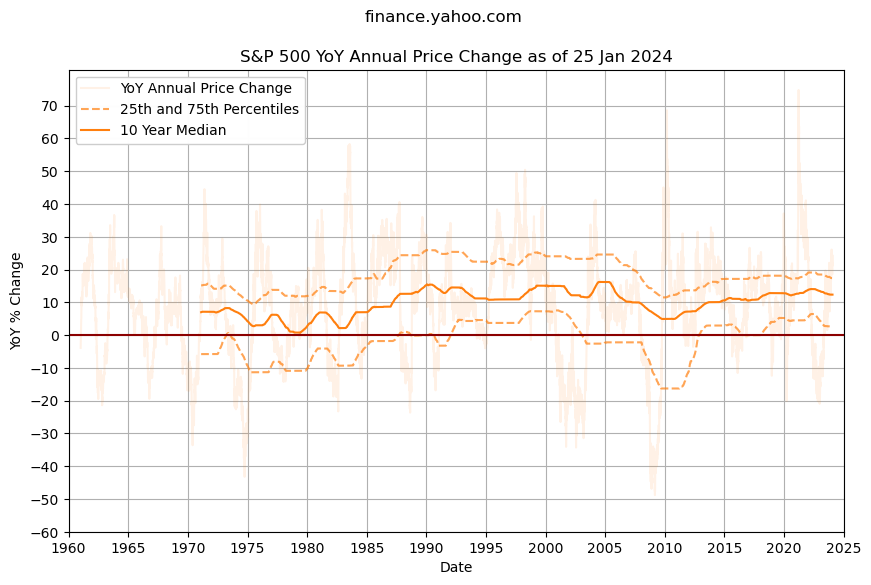

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['YoY'], label='YoY Annual Price Change', color=colors[1]['color'], alpha=0.1)
quantile_label = str(int(quantile_lower*100)) + 'th and ' + str(int(quantile_upper*100)) + 'th Percentiles'
plt.plot(df.index, df['MY_lower'], color=colors[1]['color'], linestyle='--', alpha=0.7, label=quantile_label)
plt.plot(df.index, df['MY_median'], color=colors[1]['color'], label=str(multi_year) + ' Year Median')
plt.plot(df.index, df['MY_upper'], color=colors[1]['color'], linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.suptitle('finance.yahoo.com')
plt.title('S&P 500 YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
top_limit = 80
bottom_limit = -60
#plt.ylim(bottom=bottom_limit, top=top_limit)
plt.yticks(range(bottom_limit, top_limit, 10))
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.axhline(y=0, color='darkred')  # Add horizontal line at y=0
plt.grid(True)

legend = plt.legend() #loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)

plt.savefig(os.path.join('..', 'pages', 'images', 'spx-yoy.png'), bbox_inches='tight')
plt.show()